In [63]:
import requests
import pandas as pd
from wikipedia import WikipediaPage
import bs4
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import networkx as nx
plt.style.use('ggplot') 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def find_band_page(band):
    '''
    Use the Wikipedia API to find the proper band page. Run through variants before
    trying the raw band name in case the band is named after something more important
    that has its own page (e.g. Interpol)
    '''
    try:
        try:
            band_page = WikipediaPage(title=band+ ' (band)')
        except:
            try:
                band_page = WikipediaPage(title='The '+band+' (band)')
            except:
                try:
                    band_page = WikipediaPage(title='The '+band)
                except:
                    band_page = WikipediaPage(title=band)
        return band_page.title.replace(' ','_')
    except:
        return 'band not found'

def find_members(band,main_members=[]):
    '''
    Scrape the wikipedia page to find the Members section (this isn't in the API).
    Include a list of the main band members so we don't just link back to main band.
    '''
    url = 'https://en.wikipedia.org/wiki/'+band
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    try:
        members_parent = soup.find('th', string='Members').parent
        members = members_parent.findAll('a')
        clean_members = []
        for member in members:
            if member.get('title') and member.get_text() not in main_members:
                clean_members.append(member)
        return clean_members
    except:
        # if the band no longer exists, check for a 'Past members' section
        try:
            members_parent = soup.find('th', string='Past members').parent
            members = members_parent.findAll('a')
            clean_members = []
            for member in members:
                if member.get('title') and member.get_text() not in main_members:
                    clean_members.append(member)
            return clean_members
        except:
            return ''
        
def get_members(band):
    '''
    This is for the main band, where we're not necessarily passing in the correct page name.
    '''
    band_page = find_band_page(band)
    members = find_members(band_page)
    if members:
        return members

In [3]:
def find_acts(member_link, band_page, member_list):
    url = 'https://en.wikipedia.org'+member_link
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    try:
        acts_parent = soup.find('th', string='Associated acts').parent
        acts = acts_parent.findAll('a')
        clean_acts = []
        for act in acts:
            if band_page not in act.get('href') and act.get_text() not in member_list:
                clean_acts.append(act)
        return clean_acts
    except:
        return ''

In [4]:
def return_bands(band_page,main_members=[]):
    bands = {}
    members = find_members(band_page,main_members)
    if members:
        member_list = [x.get_text() for x in members]
        for member in members:
            bands[member.get_text()]=find_acts(member.get('href'),band_page,member_list)
        return bands
    else:
        return ''

In [15]:
def get_all_bands(band):
    all_bands = {}
    band_page = find_band_page(band)
    all_bands[band] = return_bands(band_page)
    main_members = [x.get_text() for x in get_members(band_page)]
    for sub_band in [y for x in all_bands[band].values() for y in x]:
        sub_band_page = sub_band.get('href').replace('/wiki/','')
        all_bands[sub_band.get_text()] = return_bands(sub_band_page, main_members)
    return all_bands

In [19]:
# main nodes:
fugazi_bands.keys()

dict_keys(['Fugazi', 'Minor Threat', 'Teen Idles', 'The Evens', 'Embrace', 'Egg Hunt', 'Skewbald/Grand Union', 'Pailhead', 'Ataxia', 'Rites of Spring', 'Happy Go Licky', 'Girls Against Boys', 'One Last Wish'])

In [47]:
# sub-nodes
main_band = 'Fugazi'
sub_nodes = []
for key, value in fugazi_bands.items():
    if isinstance(value,dict) and key!=main_band:
        for sub_value in value.values():
            for band in sub_value:
                sub_nodes.append(band.get_text())

In [43]:
# edges:
edges = []
for key, value in fugazi_bands.items():
    if isinstance(value,dict):
        for sub_key, sub_value in value.items():
            for band in sub_value:
                edges.append((key, band.get_text(), sub_key))

In [44]:
edges

[('Fugazi', 'Minor Threat', 'Ian MacKaye'),
 ('Fugazi', 'Teen Idles', 'Ian MacKaye'),
 ('Fugazi', 'The Evens', 'Ian MacKaye'),
 ('Fugazi', 'Embrace', 'Ian MacKaye'),
 ('Fugazi', 'Egg Hunt', 'Ian MacKaye'),
 ('Fugazi', 'Skewbald/Grand Union', 'Ian MacKaye'),
 ('Fugazi', 'Pailhead', 'Ian MacKaye'),
 ('Fugazi', 'Ataxia', 'Joe Lally'),
 ('Fugazi', 'Rites of Spring', 'Brendan Canty'),
 ('Fugazi', 'Happy Go Licky', 'Brendan Canty'),
 ('Fugazi', 'Girls Against Boys', 'Brendan Canty'),
 ('Fugazi', 'Rites of Spring', 'Guy Picciotto'),
 ('Fugazi', 'Happy Go Licky', 'Guy Picciotto'),
 ('Fugazi', 'One Last Wish', 'Guy Picciotto'),
 ('Minor Threat', 'Samhain', 'Brian Baker'),
 ('Minor Threat', 'Dag Nasty', 'Brian Baker'),
 ('Minor Threat', 'The Meatmen', 'Brian Baker'),
 ('Minor Threat', 'Bad Religion', 'Brian Baker'),
 ('Minor Threat', 'Government Issue', 'Brian Baker'),
 ('Minor Threat', 'Junkyard', 'Brian Baker'),
 ('Minor Threat', 'State of Alert', 'Lyle Preslar'),
 ('Minor Threat', 'The Meatme

### Building the graph:

Nodes are:
- the main dictionary keys (bands linked to main band members)
- values of sub dictionaries apart from main band (bands linked to members of linked bands)

Edges are:
- keys of all sub dictionaries (members of main band and members of linked bands)

Values of main band sub dictionary aren't needed as they're replicated as keys in the main dictionary.

In [57]:
def get_nodes_edges(main_band, band_dict):
    
    main_nodes = band_dict.keys()
    
    sub_nodes = []
    for key, value in band_dict.items():
        if isinstance(value,dict) and key!=main_band:
            for sub_value in value.values():
                for band in sub_value:
                    sub_nodes.append(band.get_text())

    edges = []
    for key, value in band_dict.items():
        if isinstance(value,dict):
            for sub_key, sub_value in value.items():
                for band in sub_value:
                    edges.append((key, band.get_text(), sub_key))
                    
    return (main_nodes, sub_nodes, edges)
    
def build_graph(band_dict, main_nodes, sub_nodes, edges):
    
    G = nx.Graph()
    
    G.add_nodes_from(main_nodes)
    G.add_nodes_from(sub_nodes)
    
    for band1, band2, member in edges:
        G.add_edge(band1, band2, name=member)
    return G

In [58]:
band = 'Fugazi'
fugazi_bands = get_all_bands(band)
nodes1, nodes2, edges = get_nodes_edges(band, fugazi_bands)
fugazi_graph = build_graph(fugazi_bands, nodes1, nodes2, edges)

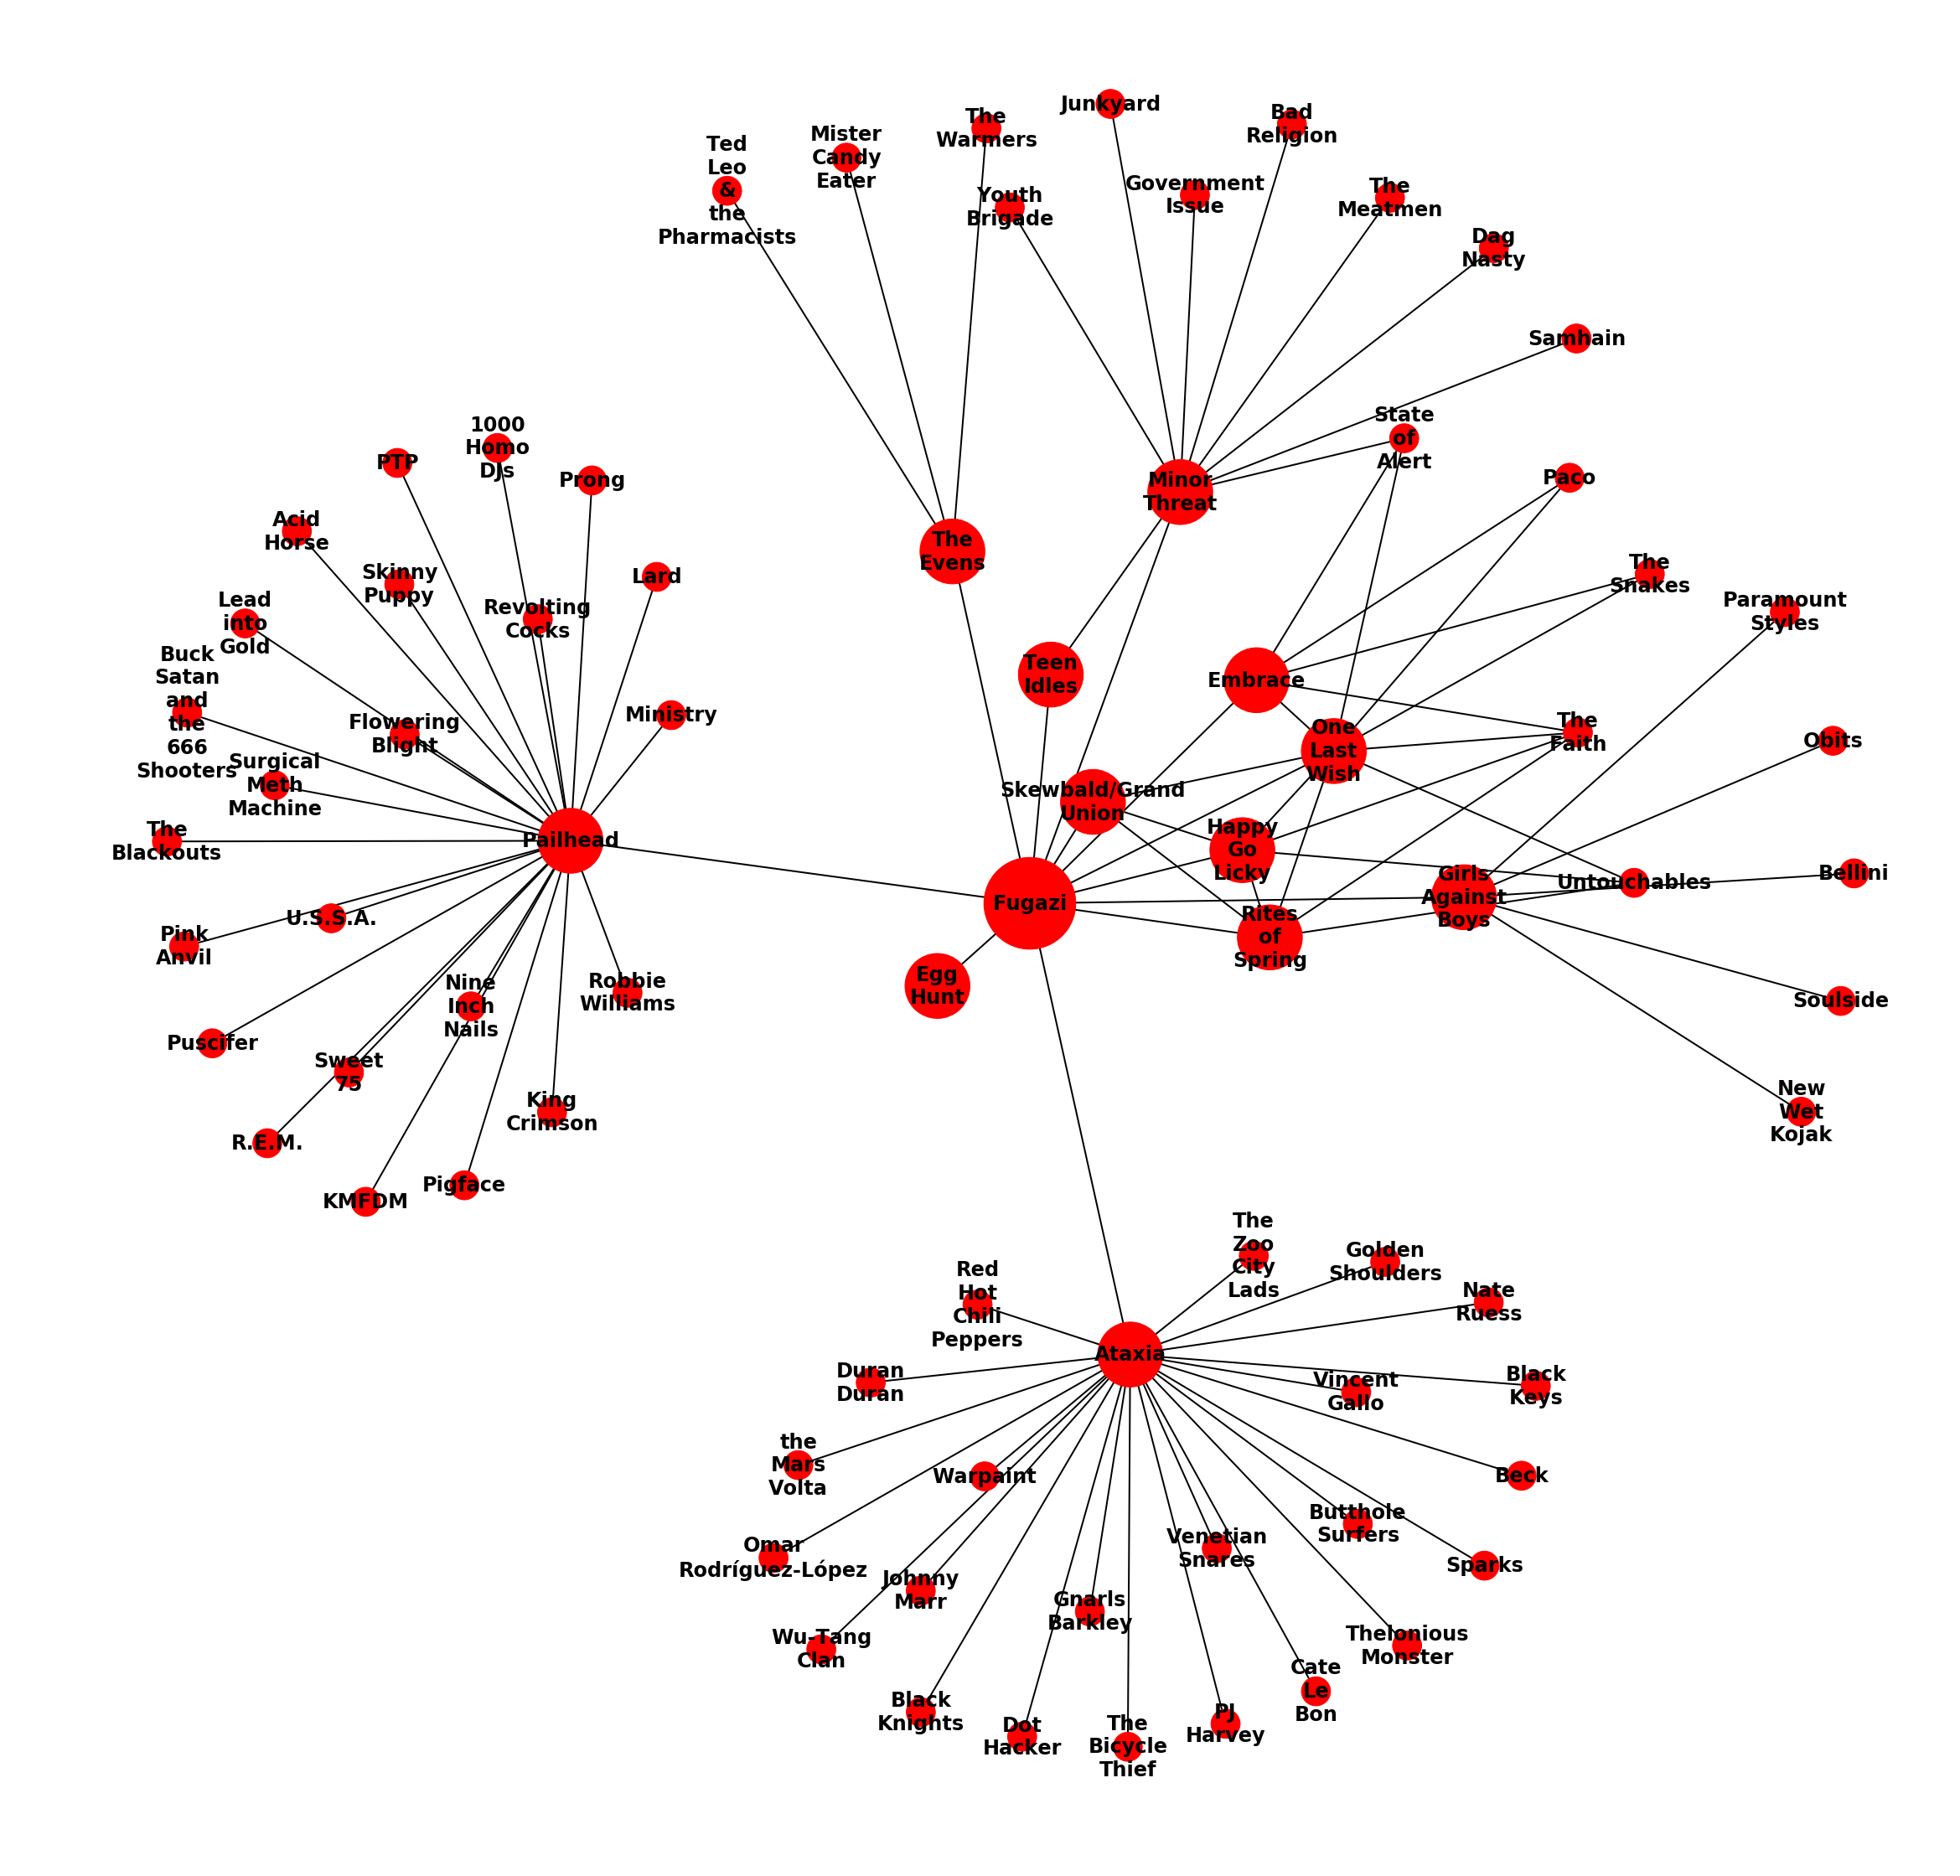

In [67]:
labels = {a:b for a,b in zip(fugazi_graph.nodes,[x.replace(' ','\n') for x in fugazi_graph.nodes])}
node_sizes = pd.Series(fugazi_graph.nodes).map(lambda x: 3000 if x=='Fugazi' else 1500 if x in nodes1 else 300)
fig, ax = plt.subplots(figsize=(20,20))
nx.draw_kamada_kawai(fugazi_graph,
                     labels=labels,
                     node_size=node_sizes,
#                      node_size=4000,
                     node_shape='o',width=1,
                     font_color='black',font_weight='bold',
                     ax=ax)
plt.show();

### Looking good, but I want to see if we can pull the band members from the end nodes and cross reference against the other bands to get more edges.